# A glimpse of ChoCo

### Notes on the format of statistics in this notebook

- **Duration**, per score and audio, distplot for each (+ mu and std in text)
- **Type**: proportion of score/audio can be mentioned in text, or table.

- **Identifiers**, mentioned in text -- number, proportion and counts.
- **Composers** and **performers**  -- number, proportion, and counts.
- **No. of annotations** (in total), just mention in text.

#### Per annotation namespace (e.g. key, chord in Harte)

- Annotation type: count, not interesting if separated because many keys-chords would follow the same (can avoid).
- **Annotators**, same as before, mention for how many this is available, possibly mention the top 3.

- **No. of observations** (and **unique**): distplot + reference to mean and std
    - For keys, we can filter out the global, and report for when more are given (to avoid inflating 1s).
- **Observation occurrences** (and **w/o reps**), plot histograms of count with relative freqs as plot annotation.

- **N-grams**, same as before. Maybe use table if this is cluttered by labels.

- Durations of observations, per audio and score separately, distplot of averages.

PS: Some of these annotation statistics may make sense only for chords, and not for keys. We can choose a subset of them for keys.

In [1]:
import os
import sys
import copy
import glob
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown as md

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "choco"))

from jams_stats import ChoCoAnnotationStats, ChoCoDatasetStats, StatsExtractorState
from utils import stringify_dict

# Choose plotting style
sns.set_style("whitegrid")
sns.set_style("darkgrid")

In [2]:
from collections import Counter

def plot_counter(cnt:Counter, name:str, horizontal=False, show_pcts=True,
    first_n=100, title="", ax=None, figsize=(10, 4), title_fs=12):

    fig, ax = plt.subplots(figsize=figsize) if ax is None else (None, ax)

    truncated_cnt = cnt.most_common()[:first_n]
    count_df = pd.DataFrame(truncated_cnt, columns=[name, "count"])
    pcts = round(count_df["count"] / sum(cnt.values()), 2)

    x, y = (name, "count") if not horizontal else ("count", name)
    ax = sns.barplot(x=x, y=y, data=count_df, ax=ax)

    if show_pcts:  # plot percentages as relative counts
        ax.bar_label(ax.containers[0], pcts, label_type='center')
    ax.set_title(title, fontsize=title_fs)
    
    return ax


def plot_histogram(values:list, unit:str, title="", ax=None, figsize=(10, 4),
    title_fs=12):
    
    fig, ax = plt.subplots(figsize=figsize) if ax is None else (None, ax)
    sns.histplot(values, kde=True, stat="density", ax=ax)

    ax.set_xlabel(unit)
    ax.set_title(title, fontsize=title_fs)

    return ax


def plot_violins(values:list, unit:str, title="", ax=None, figsize=(10, 4)):
    
    fig, ax = plt.subplots(figsize=figsize) if ax is None else (None, ax)
    values_filt = [x for x in values if x is not None]
    sns.violinplot(x=values_filt, ax=ax)

    ax.set_xlabel(unit)
    ax.set_title(title)

    return ax


def create_ngram_df(ngram_cnt:Counter, name:str, first_n=None):

    ngram_records = ngram_cnt.most_common(first_n)  # get ngram tuples
    ngram_df = []  # holding ngram dictionaries, incrementally
    for ngram_record in ngram_records:
        ngram, cnt = ngram_record
        ngram_df.append({**{f"{name}_{i+1}": c for i, c in enumerate(ngram)},
                         **{"cnt": cnt}})  # append actual ngram count

    ngram_df = pd.DataFrame(ngram_df)
    return ngram_df

In [3]:
jams_stats_file = "../choco-jams/jams_stats.joblib"
dataset_stats_file = "../choco-jams/dataset_stats.joblib"

In [4]:
# with open(jams_stats_file, 'rb') as jobfile:
#     jams_stats = joblib.load(jobfile)
# print(f"{len(jams_stats)} JAMS stats")

with open(dataset_stats_file, 'rb') as jobfile:
    data_stats = joblib.load(jobfile)


## Meta-stats

In [5]:
no_jams, no_annotations = data_stats.no_processed_elements
annotation_stats = data_stats._annotation_stats_ext

In [6]:
annotations_per_namespace = [f"{extractor.no_processed_elements} {name} annotations" for name, extractor in annotation_stats.items()]

md(f"The dataset contains {no_jams} JAMS files: {len(data_stats._durations['audio']['values'])} audio JAMS and {len(data_stats._durations['score']['values'])} score JAMS.\n"
f"In these ChoCo JAMS files, {no_annotations} different annotations were found: {', '.join(annotations_per_namespace)}.")

The dataset contains 20280 JAMS files: 2283 audio JAMS and 17997 score JAMS.
In these ChoCo JAMS files, 42187 different annotations were found: 4847 chord annotations, 20423 key_mode annotations, 16077 chord_harte annotations, 554 segment_open annotations, 286 beat annotations.

#### Identifiers

In [7]:
md(f"In total, {data_stats._identifiers['sum']} identifiers were found, which cover {data_stats._identifiers['proportion']*100}% of the dataset.")

In total, 771 identifiers were found, which cover 3.8017751479289945% of the dataset.

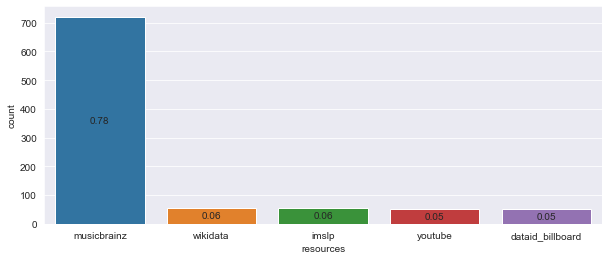

In [8]:
if data_stats._identifiers['sum'] > 0:
    plot_counter(data_stats._identifiers['cnt'], "resources")

#### Durations

In [9]:
md(f"The average duration of audio pieces is {data_stats._durations['audio']['mean']} ± {data_stats._durations['audio']['std']} seconds.\n That of score, instead, is {data_stats._durations['score']['mean']} ± {data_stats._durations['score']['std']} measures.")

# data_stats._durations["audio"]["values"]

The average duration of audio pieces is 191.29056126494467 ± 85.04922784037872 seconds.
 That of score, instead, is 74.74001236163399 ± 82.6568554850611 measures.

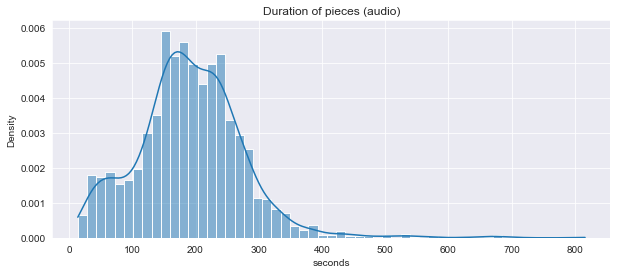

In [10]:
if data_stats._durations['audio']['values'] != []:
    plot_histogram(data_stats._durations['audio']['values'],
        "seconds", title="Duration of pieces (audio)")

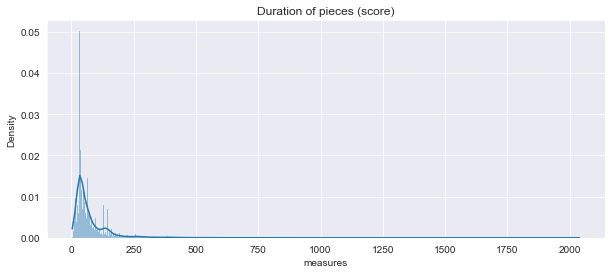

In [11]:
if data_stats._durations['score']['values'] != []:
    plot_histogram(data_stats._durations['score']['values'],
        "measures", title="Duration of pieces (score)")

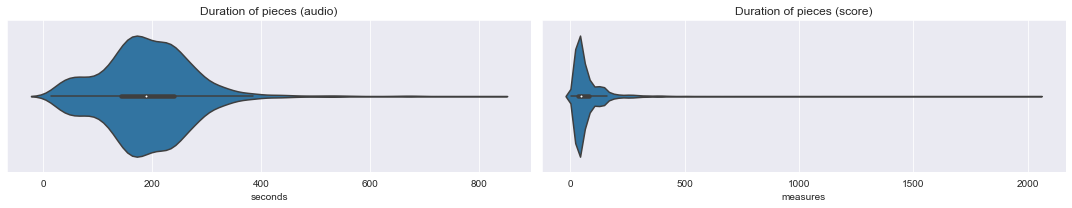

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(15,3))

if data_stats._durations['audio']['values'] != []:
    plot_violins(data_stats._durations['audio']['values'],
        "seconds", title="Duration of pieces (audio)", ax=axes[0])

if data_stats._durations['score']['values'] != []:
    plot_violins(data_stats._durations['score']['values'],
        "measures", title="Duration of pieces (score)", ax=axes[1])

plt.tight_layout()
plt.savefig("../assets/stats/piece_durations.pdf")

#### Composers and performers

In [13]:
md(f"In the enriched metadata, {data_stats._performers['sum']} performers were found in the JAMS, which covers {data_stats._performers['proportion']*100}% of the whole dataset. Analogously, a total of  {data_stats._composers['sum']} composers were found ({data_stats._composers['proportion']*100}% coverage).")

In the enriched metadata, 2483 performers were found in the JAMS, which covers 12.243589743589743% of the whole dataset. Analogously, a total of  7478 composers were found (36.87376725838264% coverage).

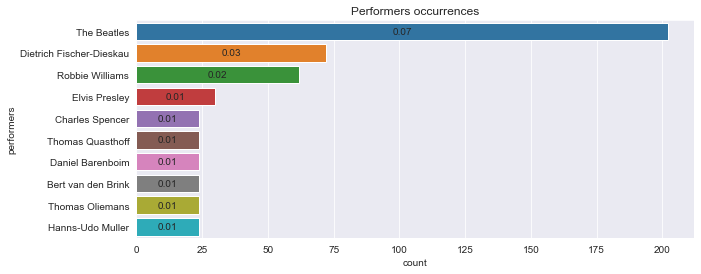

In [14]:
if data_stats._performers['sum'] > 0:
    plot_counter(data_stats._performers["cnt"], "performers", first_n=10,
                title="Performers occurrences", horizontal=True)

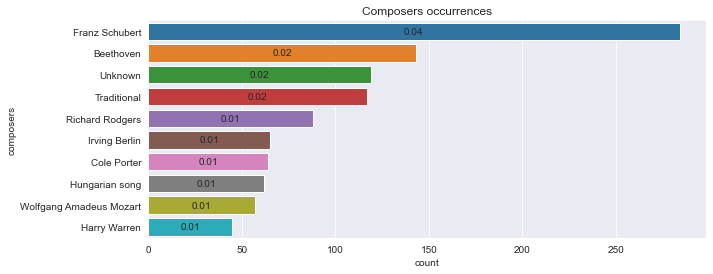

In [15]:
if data_stats._composers['sum'] > 0:
    plot_counter(data_stats._composers["cnt"], "composers", first_n=10,
                title="Composers occurrences", horizontal=True)

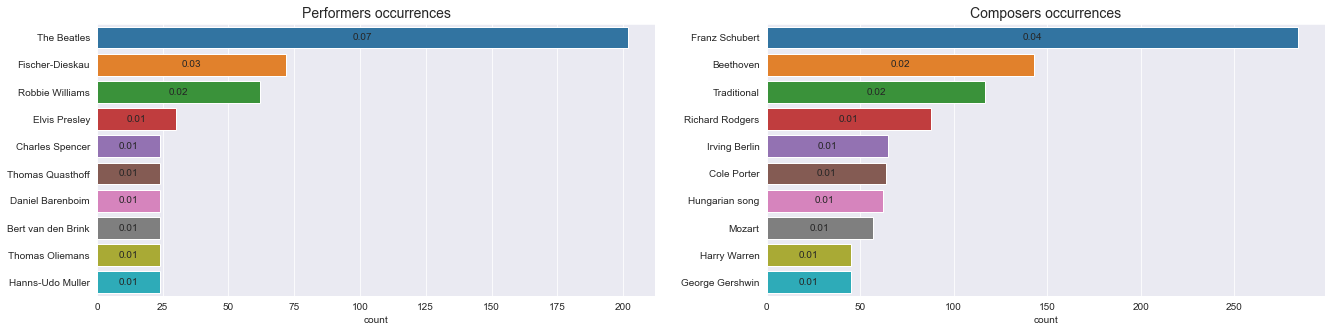

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(22,5))

if data_stats._performers['sum'] > 0:
    # Simplifying long names of performers
    real_performers_cnt = copy.deepcopy(data_stats._performers["cnt"])
    real_performers_cnt["Fischer-Dieskau"] = real_performers_cnt["Dietrich Fischer-Dieskau"]
    real_performers_cnt["Dietrich Fischer-Dieskau"] = 0
    plot_counter(real_performers_cnt, "performers", first_n=10,
                title="Performers occurrences", title_fs=14,
                horizontal=True, ax=axes[0])
    axes[0].set_ylabel("")

if data_stats._composers['sum'] > 0:
    real_composers_cnt = copy.deepcopy(data_stats._composers["cnt"])
    real_composers_cnt["Mozart"] = real_composers_cnt["Wolfgang Amadeus Mozart"]
    real_composers_cnt["Wolfgang Amadeus Mozart"] = 0
    real_composers_cnt["Unknown"] = 0
    plot_counter(real_composers_cnt, "composers", first_n=10,
                title="Composers occurrences", title_fs=14,
                horizontal=True, ax=axes[1])
    # axes[1].invert_xaxis()  # labels read top-to-bottom
    # axes[1].yaxis.set_label_position('right')
    # axes[1].yaxis.set_ticks_position('right')
    # axes[1].tick_params(right=False)
    axes[1].set_ylabel("")

# plt.tight_layout()
plt.savefig("../assets/stats/artists.pdf")

## Content-stats


In [17]:
print(f"Choose one of these: {list(annotation_stats.keys())}")

NAMESPACE = "chord"  # the name of the original (or marged)
DESCRIPTION = "chords"

Choose one of these: ['chord', 'key_mode', 'chord_harte', 'segment_open', 'beat']


In [18]:
use_merged_chords = True

if use_merged_chords:
    sel_annotations_stats = annotation_stats["chord_harte"]
    sel_annotations_stats.update_annotation_stats(annotation_stats["chord"])
else:  # custom selection from above
    sel_annotations_stats = data_stats._annotation_stats_ext[NAMESPACE]

Merging stats from different namespace: expected namespace chord_harte (this object) but chord was found!


#### Annotators and annotation types

In [19]:
all_annotators =  sum(sel_annotations_stats._annotators['cnt'].values())
real_annotators = sum([c for name, c \
    in sel_annotations_stats._annotators['cnt'].items() if name != "Unknown"])

md(f"Number of annotators for which their identity is known: {real_annotators}, covering {sel_annotations_stats._annotators['proportion']*100}% of {NAMESPACE} annotations.")

Number of annotators for which their identity is known: 996, covering 4.76008411393615% of chord annotations.

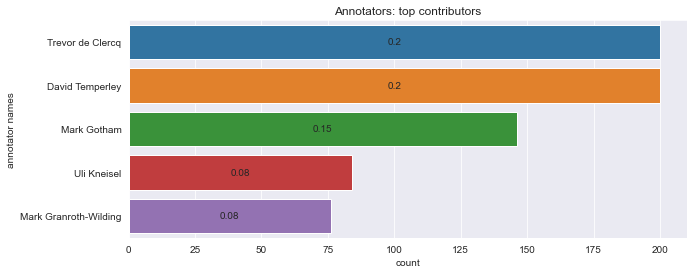

In [20]:
if real_annotators > 0:
    real_annotators_cnt = copy.deepcopy(sel_annotations_stats._annotators['cnt'])
    real_annotators_cnt["Unknown"] = 0
    plot_counter(real_annotators_cnt, "annotator names", first_n=5,
                title="Annotators: top contributors", horizontal=True)

#### Observation occurrences

In [21]:
total_occurrences = sum(sel_annotations_stats._no_observations["values"])
total_occurrences_uniq = sum(sel_annotations_stats._no_observations_uniq["values"])

md(f"Overall, there are {total_occurrences} {NAMESPACE} occurrences/observations in the dataset, and an average annotation has {sel_annotations_stats._no_observations['mean']:.2f} ± {sel_annotations_stats._no_observations['std']:.2f} {DESCRIPTION}. When looking at unique occurrences (measuring the diversity of the annotation values), there are {total_occurrences_uniq} unique occurrences. An annotation, on average, uses {sel_annotations_stats._no_observations_uniq['mean']:.2f} ± {sel_annotations_stats._no_observations_uniq['std']:.2f} classes (unique {DESCRIPTION}).")

Overall, there are 1642625 chord occurrences/observations in the dataset, and an average annotation has 78.50 ± 85.96 chords. When looking at unique occurrences (measuring the diversity of the annotation values), there are 311486 unique occurrences. An annotation, on average, uses 14.89 ± 11.14 classes (unique chords).

<AxesSubplot:title={'center':'Number of chord observations in annotations'}, xlabel='chords', ylabel='Density'>

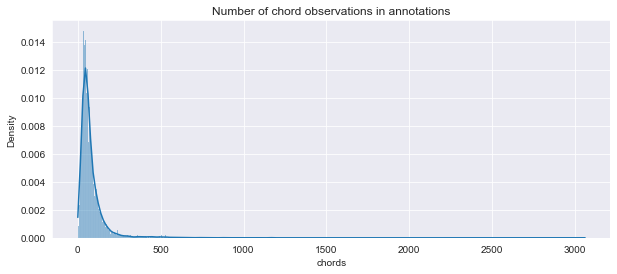

In [22]:

plot_histogram(sel_annotations_stats._no_observations["values"],
    DESCRIPTION, title=f"Number of {NAMESPACE} observations in annotations")

<AxesSubplot:title={'center':'Number of unique chord classes in annotations'}, xlabel='chords', ylabel='Density'>

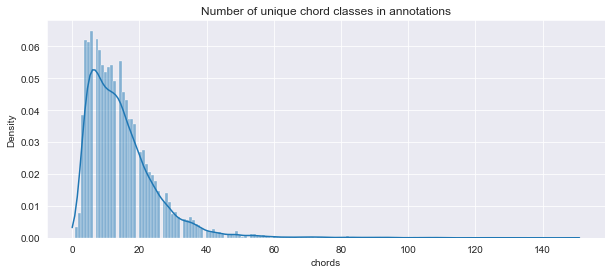

In [23]:

plot_histogram(sel_annotations_stats._no_observations_uniq["values"],
    DESCRIPTION, title=f"Number of unique {NAMESPACE} classes in annotations")

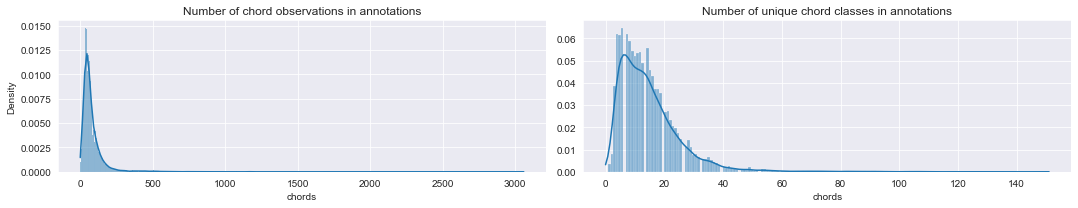

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(15,3))

plot_histogram(sel_annotations_stats._no_observations["values"],
    DESCRIPTION, title=f"Number of {NAMESPACE} observations in annotations",
    ax=axes[0])

plot_histogram(sel_annotations_stats._no_observations_uniq["values"],
    DESCRIPTION, title=f"Number of unique {NAMESPACE} classes in annotations",
    ax=axes[1])

axes[1].set_ylabel("")
plt.tight_layout()

plt.savefig("../assets/stats/observation_densities.pdf")

#### Observation values

##### [Observation values] all, with no preprocessing

In [25]:
FIRST_N = 15

# Occurrences of classes accumulated across the whole dataset: as if the dataset
# is a unique annotation (e.g. a very long chord progression)
# sel_annotations_stats._observation_cnt_all_abs.most_common(FIRST_N)

In [26]:
# Relative occurrences of classes, first normalised per annotation, then aggregated
sel_annotations_stats._observation_cnt_all_rel.most_common(FIRST_N)

[('C:maj', 5.198801514779659e-06),
 ('G:maj', 4.6071548666931695e-06),
 ('F:maj', 3.882392484269446e-06),
 ('G:7', 3.3970462090785314e-06),
 ('D:maj', 3.170868391277225e-06),
 ('C:7', 2.935565271943339e-06),
 ('D:7', 2.777943327410703e-06),
 ('Bb:maj', 2.4338275758869355e-06),
 ('A:maj', 2.109236563115406e-06),
 ('F:7', 2.0958721312208985e-06),
 ('A:7', 2.0064921909888356e-06),
 ('Bb:7', 1.811118848275646e-06),
 ('Eb:maj', 1.72749272268388e-06),
 ('A:min', 1.6953293513090274e-06),
 ('D:min7', 1.43653045371173e-06)]

Text(0, 0.5, '')

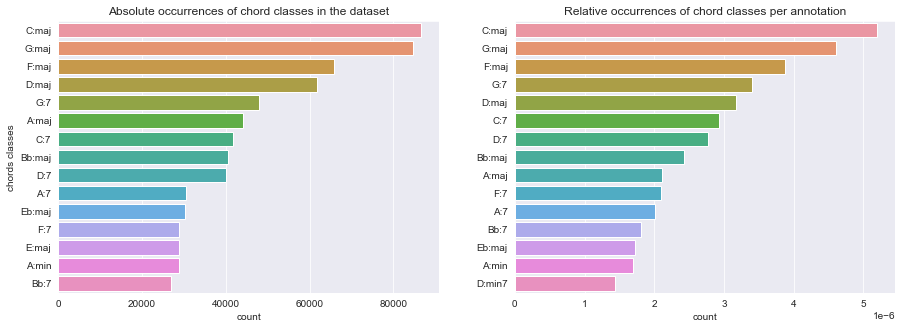

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_all_abs,
    f"{DESCRIPTION} classes", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} classes in the dataset", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_all_rel,
    f"{DESCRIPTION} classes", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} classes per annotation", horizontal=True)

ax[1].set_ylabel("")
# plt.tight_layout()

##### [Observation values] after removal of consecutively repeated occurrences

In [28]:
sel_annotations_stats._observation_cnt_norep_abs.most_common(FIRST_N)  # Absolute occurrences

[('C:maj', 69583),
 ('G:maj', 66501),
 ('F:maj', 55180),
 ('D:maj', 47979),
 ('G:7', 43661),
 ('C:7', 38103),
 ('D:7', 36264),
 ('A:maj', 33853),
 ('Bb:maj', 33148),
 ('A:7', 27802),
 ('F:7', 25956),
 ('Eb:maj', 25248),
 ('Bb:7', 24713),
 ('A:min', 23896),
 ('E:maj', 20583)]

In [29]:
sel_annotations_stats._observation_cnt_norep_rel.most_common(FIRST_N)  # Relative occurrences

[('C:maj', 5.0366698414339966e-06),
 ('G:maj', 4.4932850988043685e-06),
 ('F:maj', 3.827974559425843e-06),
 ('G:7', 3.4488851250031915e-06),
 ('D:maj', 3.038824823534651e-06),
 ('C:7', 2.986598842085715e-06),
 ('D:7', 2.8624558568979228e-06),
 ('Bb:maj', 2.385882056793592e-06),
 ('F:7', 2.1343245945101062e-06),
 ('A:7', 2.0876438316638273e-06),
 ('A:maj', 2.0582631116743055e-06),
 ('Bb:7', 1.837898137696784e-06),
 ('A:min', 1.662481533467151e-06),
 ('Eb:maj', 1.6541401428158466e-06),
 ('D:min7', 1.4459276118155937e-06)]

<AxesSubplot:title={'center':'Relative occurrences of chord classes per annotation (no repetitions)'}, xlabel='count', ylabel='chords classes'>

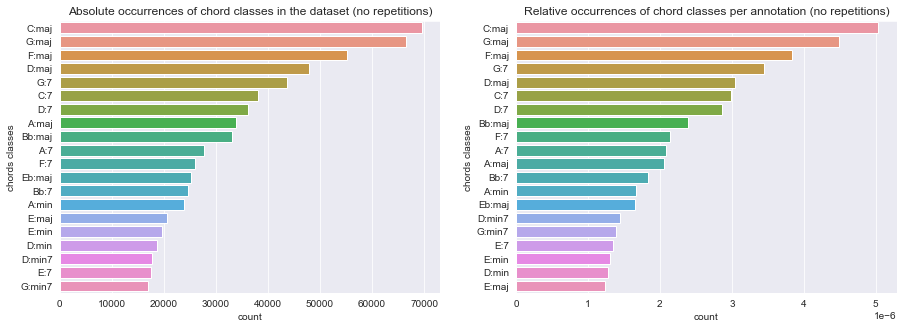

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_norep_abs,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} classes in the dataset (no repetitions)", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_norep_rel,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} classes per annotation (no repetitions)", horizontal=True)

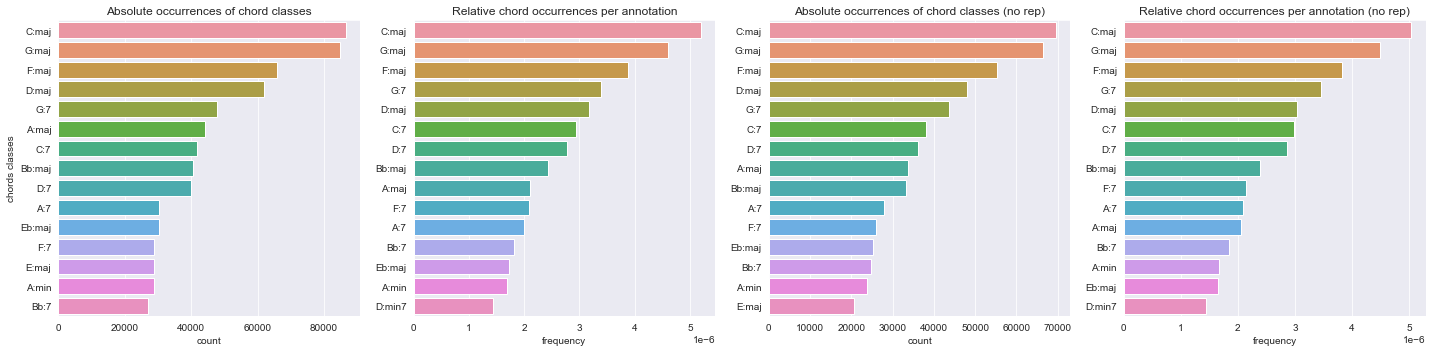

In [31]:
# All plots condensed in  one

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))

plot_counter(sel_annotations_stats._observation_cnt_all_abs,
    f"{DESCRIPTION} classes", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} classes",
    horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_all_rel,
    f"{DESCRIPTION} classes", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative {NAMESPACE} occurrences per annotation",
    horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_norep_abs,
    f"{DESCRIPTION} classes", first_n=FIRST_N, show_pcts=False, ax=ax[2],
    title=f"Absolute occurrences of {NAMESPACE} classes (no rep)",
    horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_norep_rel,
    f"{DESCRIPTION} classes", first_n=FIRST_N, show_pcts=False, ax=ax[3],
    title=f"Relative {NAMESPACE} occurrences per annotation (no rep)",
    horizontal=True)

ax[1].set_ylabel("")
ax[1].set_xlabel("frequency")
ax[2].set_ylabel("")
ax[3].set_ylabel("")
ax[3].set_xlabel("frequency")

plt.tight_layout()
plt.savefig("../assets/stats/chord_occurrences.pdf")

##### Duration of observations

In [32]:
md(f"The average duration of {NAMESPACE} observations in audio and score JAMS is: {sel_annotations_stats._observation_dur_avgs['audio']['mean']} ± {sel_annotations_stats._observation_dur_avgs['audio']['std']} seconds and {np.nanmean(sel_annotations_stats._observation_dur_avgs['score']['values'])} ± {np.nanstd(sel_annotations_stats._observation_dur_avgs['score']['values'])} beats.")

The average duration of chord observations in audio and score JAMS is: 2.8500638975751644 ± 12.558620734816389 seconds and 3.1959410244874644 ± 8.59319571607309 beats.

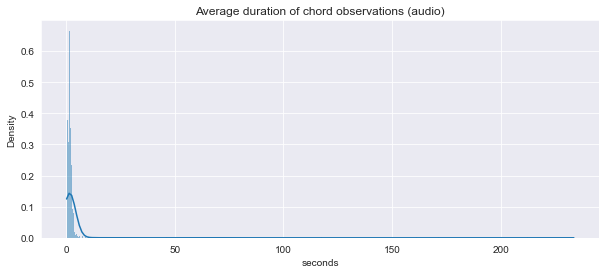

In [33]:
if len(sel_annotations_stats._observation_dur_avgs['audio']["values"]) > 0:
    plot_histogram(sel_annotations_stats._observation_dur_avgs['audio']["values"],
        "seconds", title=f"Average duration of {NAMESPACE} observations (audio)")

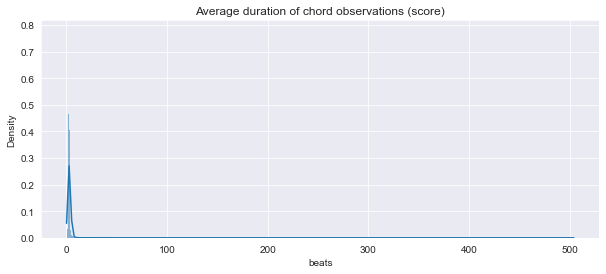

In [34]:
if len(sel_annotations_stats._observation_dur_avgs['score']["values"]) > 0:
    plot_histogram(sel_annotations_stats._observation_dur_avgs['score']["values"],
        "beats", title=f"Average duration of {NAMESPACE} observations (score)")

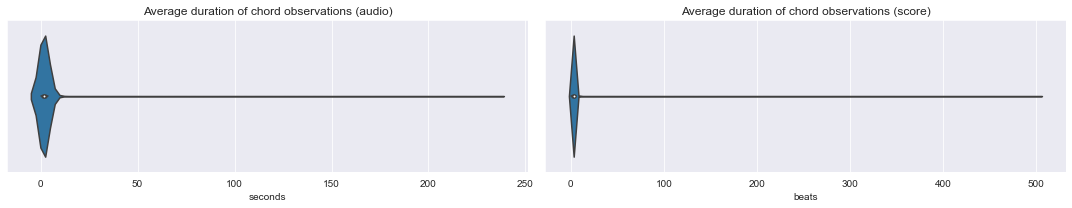

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(15,3))

if len(sel_annotations_stats._observation_dur_avgs['audio']["values"]) > 0:
    plot_violins(sel_annotations_stats._observation_dur_avgs['audio']["values"],
        "seconds", title=f"Average duration of {NAMESPACE} observations (audio)", ax=axes[0])

if len(sel_annotations_stats._observation_dur_avgs['score']["values"]) > 0:
    plot_violins(sel_annotations_stats._observation_dur_avgs['score']["values"],
        "beats", title=f"Average duration of {NAMESPACE} observations (score)", ax=axes[1])

plt.tight_layout()

#### Patterns

##### Patterns: 2-gram

In [36]:
# Absolute occurrences of 2-gram observations
bigram_abs = create_ngram_df(
    sel_annotations_stats._observation_cnt_2g_abs,
    name=NAMESPACE, first_n=None)

bigram_abs[:FIRST_N]

,chord_1,chord_2,cnt
0,G:7,C:maj,16697
1,C:7,F:maj,13674
2,D:7,G:maj,13154
3,G:maj,C:maj,11966
4,D:maj,G:maj,11751
5,C:maj,G:maj,10408
6,C:maj,F:maj,10300
7,G:maj,D:maj,10142
8,A:7,D:maj,9952
9,F:maj,C:maj,8965


In [37]:
# Relative occurrences of 2-gram observations
bigram_rel = create_ngram_df(
    sel_annotations_stats._observation_cnt_2g_rel,
    name=NAMESPACE, first_n=None)

# Merge to retrieve absolute occurrences
bigram_rel.rename({"cnt": "frequency"}, axis=1, inplace=True)
bigram_rel = pd.merge(bigram_rel, bigram_abs, on=["chord_1", "chord_2"])
bigram_rel = bigram_rel[:FIRST_N]  # keep top occurrences

bigram_rel.insert(0, "order", 2)
bigram_rel.insert(0, "rank", np.arange(FIRST_N) + 1)

bigram_rel

,rank,order,chord_1,chord_2,frequency,cnt
0,1,2,G:7,C:maj,1.423514e-06,16697
1,2,2,C:7,F:maj,1.114882e-06,13674
2,3,2,D:7,G:maj,1.064627e-06,13154
3,4,2,G:maj,C:maj,8.590354e-07,11966
4,5,2,C:maj,G:maj,7.757505e-07,10408
5,6,2,C:maj,F:maj,7.216686e-07,10300
6,7,2,D:maj,G:maj,7.200894e-07,11751
7,8,2,A:7,D:maj,6.936772e-07,9952
8,9,2,F:7,Bb:maj,6.797478e-07,7770
9,10,2,F:maj,C:maj,6.655491e-07,8965


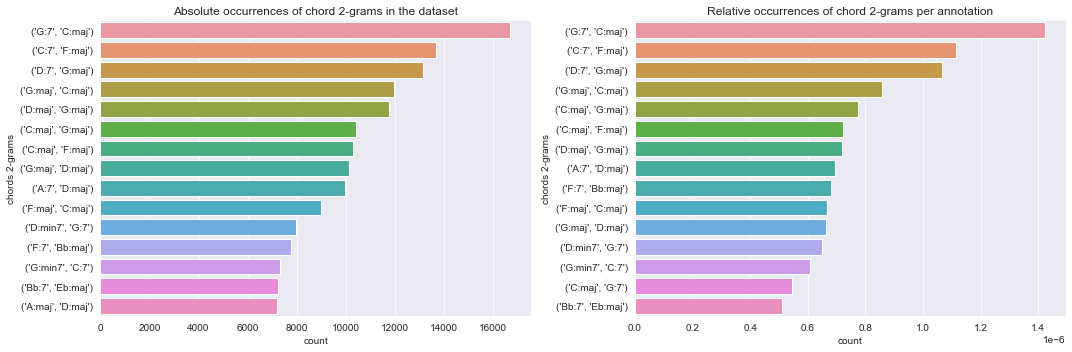

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_2g_abs,
    f"{DESCRIPTION} 2-grams", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} 2-grams in the dataset", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_2g_rel,
    f"{DESCRIPTION} 2-grams", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} 2-grams per annotation", horizontal=True)

plt.tight_layout()

##### Patterns: 3-gram

In [39]:
# Absolute occurrences of 3-gram observations
trigram_abs = create_ngram_df(
    sel_annotations_stats._observation_cnt_3g_abs,
    name=NAMESPACE, first_n=None)

trigram_abs

,chord_1,chord_2,chord_3,cnt
0,D:maj,G:maj,D:maj,4716
1,G:maj,C:maj,G:maj,4685
2,C:maj,F:maj,C:maj,4345
3,C:maj,G:7,C:maj,4198
4,G:maj,D:7,G:maj,4077
...,...,...,...,...
269680,D:min,G:maj/3,C:7,1
269681,G:maj/3,C:7,G:maj,1
269682,G:maj,C:maj,Eb:aug,1
269683,C:maj,Eb:aug,C:maj,1


In [40]:
# Relative occurrences of 3-gram observations
trigram_rel = create_ngram_df(
    sel_annotations_stats._observation_cnt_3g_rel,
    name=NAMESPACE, first_n=None)


# Merge to retrieve absolute occurrences
trigram_rel.rename({"cnt": "frequency"}, axis=1, inplace=True)
trigram_rel = pd.merge(trigram_rel, trigram_abs,
                       on=["chord_1", "chord_2", "chord_3"])

# Filtering out uninteresting n-grams
trigram_rel = trigram_rel[trigram_rel["chord_1"] != trigram_rel["chord_3"]]
trigram_rel = trigram_rel[:FIRST_N]  # keep top occurrences

trigram_rel.insert(0, "order", 3)
trigram_rel.insert(0, "rank", np.arange(FIRST_N) + 1)

trigram_rel

,rank,order,chord_1,chord_2,chord_3,frequency,cnt
11,1,3,G:7,C:maj,F:maj,2.170300e-07,2249
12,2,3,D:7,G:maj,C:maj,2.026806e-07,2320
13,3,3,D:min7,G:7,C:maj,1.980872e-07,2293
17,4,3,D:7,G:7,C:maj,1.743409e-07,1747
20,5,3,C:maj,C:7,F:maj,1.653458e-07,1666
21,6,3,A:7,D:maj,G:maj,1.609899e-07,2589
23,7,3,G:min7,C:7,F:maj,1.556018e-07,1703
26,8,3,G:7,C:7,F:maj,1.322915e-07,1289
27,9,3,A:min,D:7,G:maj,1.317322e-07,1751
28,10,3,C:7,F:maj,Bb:maj,1.285702e-07,1490


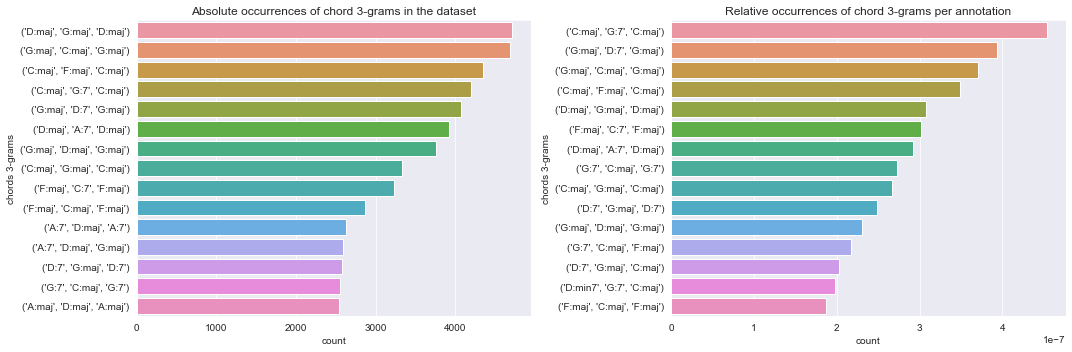

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_3g_abs,
    f"{DESCRIPTION} 3-grams", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} 3-grams in the dataset", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_3g_rel,
    f"{DESCRIPTION} 3-grams", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} 3-grams per annotation", horizontal=True)

plt.tight_layout()

##### Patterns: 4-grams

In [42]:
# Absolute occurrences of 4-gram observations
fourgram_abs = create_ngram_df(
    sel_annotations_stats._observation_cnt_4g_abs,
    name=NAMESPACE, first_n=None)

fourgram_abs[:FIRST_N]

,chord_1,chord_2,chord_3,chord_4,cnt
0,D:maj,G:maj,D:maj,G:maj,2447
1,A:7,D:maj,A:7,D:maj,2442
2,G:maj,D:maj,G:maj,D:maj,2273
3,D:7,G:maj,D:7,G:maj,2186
4,G:7,C:maj,G:7,C:maj,2046
5,G:maj,C:maj,G:maj,C:maj,2004
6,C:maj,G:maj,C:maj,G:maj,1816
7,C:maj,F:maj,C:maj,F:maj,1799
8,C:7,F:maj,C:7,F:maj,1704
9,F:maj,C:maj,F:maj,C:maj,1637


In [43]:
# Relative occurrences of 4-gram observations
fourgram_rel = create_ngram_df(
    sel_annotations_stats._observation_cnt_4g_abs,
    name=NAMESPACE, first_n=None)

# Merge to retrieve absolute occurrences
fourgram_rel.rename({"cnt": "frequency"}, axis=1, inplace=True)
fourgram_rel = pd.merge(fourgram_rel, fourgram_abs,
                       on=["chord_1", "chord_2", "chord_3", "chord_4"])

# Filtering out uninteresting n-grams
fourgram_rel = fourgram_rel[fourgram_rel["chord_1"] != fourgram_rel["chord_3"]]
fourgram_rel = fourgram_rel[:FIRST_N]  # keep top occurrences

fourgram_rel.insert(0, "order", 4)
fourgram_rel.insert(0, "rank", np.arange(FIRST_N) + 1)

fourgram_rel

,rank,order,chord_1,chord_2,chord_3,chord_4,frequency,cnt
13,1,4,D:maj,G:maj,A:7,D:maj,1258,1258
16,2,4,D:7,G:maj,C:maj,G:maj,1191,1191
21,3,4,G:7,C:maj,F:maj,C:maj,1073,1073
22,4,4,A:7,D:maj,G:maj,A:7,1058,1058
23,5,4,A:7,D:maj,G:maj,D:maj,1002,1002
24,6,4,F:maj,C:maj,G:7,C:maj,973,973
25,7,4,C:maj,G:maj,D:7,G:maj,964,964
26,8,4,G:7,C:maj,C:7,F:maj,940,940
29,9,4,D:maj,E:min,A:7,D:maj,824,824
30,10,4,G:maj,D:maj,A:7,D:maj,822,822


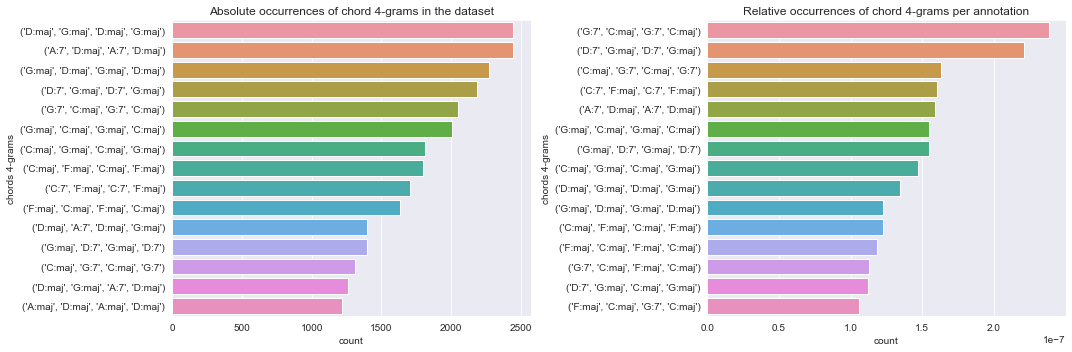

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_4g_abs,
    f"{DESCRIPTION} 4-grams", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} 4-grams in the dataset", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_4g_rel,
    f"{DESCRIPTION} 4-grams", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} 4-grams per annotation", horizontal=True)

plt.tight_layout()

In [45]:
ngram_df = pd.concat([bigram_rel, trigram_rel, fourgram_rel])

ngram_df['frequency'] = ngram_df.pop("frequency")
ngram_df['occurrences'] = ngram_df.pop("cnt")

ngram_df.reset_index(drop=True, inplace=True)
ngram_df = ngram_df.replace({None: "-"})
print(ngram_df.to_latex())

\begin{tabular}{lrrllllrr}
\toprule
{} &  rank &  order & chord\_1 & chord\_2 & chord\_3 & chord\_4 &     frequency &  occurrences \\
\midrule
0  &     1 &      2 &     G:7 &   C:maj &       - &       - &  1.423514e-06 &        16697 \\
1  &     2 &      2 &     C:7 &   F:maj &       - &       - &  1.114882e-06 &        13674 \\
2  &     3 &      2 &     D:7 &   G:maj &       - &       - &  1.064627e-06 &        13154 \\
3  &     4 &      2 &   G:maj &   C:maj &       - &       - &  8.590354e-07 &        11966 \\
4  &     5 &      2 &   C:maj &   G:maj &       - &       - &  7.757505e-07 &        10408 \\
5  &     6 &      2 &   C:maj &   F:maj &       - &       - &  7.216686e-07 &        10300 \\
6  &     7 &      2 &   D:maj &   G:maj &       - &       - &  7.200894e-07 &        11751 \\
7  &     8 &      2 &     A:7 &   D:maj &       - &       - &  6.936772e-07 &         9952 \\
8  &     9 &      2 &     F:7 &  Bb:maj &       - &       - &  6.797478e-07 &         7770 \\
9  &    10 

/var/folders/q6/phq9pwd56q78175j_yvjz8pc0000gn/T/ipykernel_78261/2587190225.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ngram_df.to_latex())
